#### **Welcome to Assignment 2**
This assignment consists of three parts. Part-1 is based on the content you learned in Week-3 of course and Part-2 is based on the content you learned in Week-4 of the course. Part-3 is **un-graded** and mainly designed to help you flex the Deep Learning muscles grown in Part-2. 

Unlike the first two parts, you'll have to implement everything from scratch in Part-3. If you find answers to questions in Part-3, feel free to head out to the forums and discuss them with your classmates!

#### **Instructions**
1. Use Python 3.x to run this notebook
2. Write your code only in between the lines 'YOUR CODE STARTS HERE' and 'YOUR CODE ENDS HERE'.
you should not change anything else in the code cells, if you do, the answers you are supposed to get at the end of this assignment might be wrong.
3. Read documentation of each function carefully.
4. All the Best!

# Part-1

In [ ]:
# Imports
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image

# %matplotlib inline uncomment this line if you're running this notebook on your local PC

In [ ]:
# DO NOT CHANGE THIS CODE
np.random.seed(10)

### Question 1 : Line detection from a given image.


Find the starting and ending point co-ordinates of detected lines of a given image (line.png) using hough transform.

Following criterion need to be satisfied to qualify as a line:

(a) Minimum line length = 60;
(b) Maximum allowed gap between line segments = 250;
(c) Accumulator threshold parameter = 15  (only those lines are returned that get enough votes);
(d) Distance resolution of the accumulator in pixels = 1;
(e) Angle resolution of the accumulator in radians = pi/180



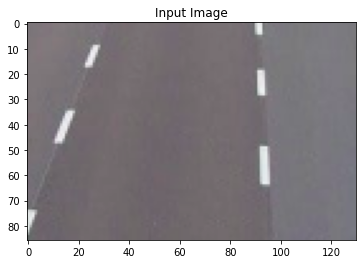

Start Point for line 1
0 83
End Point
25 9
Start Point for line 2
92 0
End Point
95 64
Start Point for line 3
1 81
End Point
27 9
Start Point for line 4
90 0
End Point
92 63


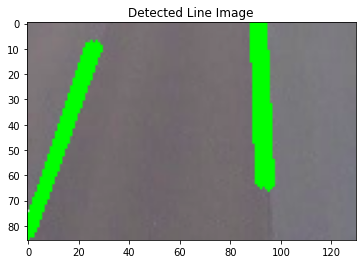

In [ ]:
#Read image 
img = cv2.imread('line.png', cv2.IMREAD_COLOR)

# Visualize the input image
plt.imshow(img)
plt.title('Input Image')
plt.show()

#### YOUR CODE STARTS HERE #####
#convert the image to gray-scale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#### YOUR CODE ENDS HERE #####

#Find the edges in the image using canny detector
edges = cv2.Canny(gray, 50, 200)

#### YOUR CODE STARTS HERE #####
lines=cv2.HoughLinesP(edges,1,np.pi/180,threshold=15,minLineLength=60, maxLineGap=250)
count=0
for line in lines:
    count=count+1
    x1=line[0,0]
    y1=line[0,1]
    x2=line[0,2]
    y2=line[0,3]
    cv2.line(img, (x1, y1), (x2, y2), (0, 255, 0), 4)
    print("Start Point for line %d" %count)
    print(x1,y1)
    print("End Point")
    print(x2,y2)
#### YOUR CODE ENDS HERE #####
plt.imshow(img)
plt.title('Detected Line Image')
plt.show()

##Question 2: Point matching using RANSAC

Given two sets of points related by affine transformation(with an outlier rate), use the RANSAC method to estimate the Affine transformation parameters between them and the number of inliers(Matching points).

What is the estimated number of inliers for an outlier rate of 0.9?


In [ ]:
import numpy as np
np.random.seed(0)


# Affine Transformation
# |x'|  = |a, b| * |x|  +  |tx|
# |y'|    |c, d|   |y|     |ty|
# points_t =    A   * points_s  + t

# -------------------------------------------------------------

class Transform():

    def create_case(self, out_rate):
        ''' CREATE_CASE

            Method to generate a test case for affine transformation

            Input arguments:
            - out_rate : the percentage of outliers in test case

            Outputs:
            - points_s : Source points that will be transformed
            - points_t : warped points
            - A, t : parameters of affine transformation, A is a 2x2
            matrix, t is a 2x1 vector, both of them are created randomly

        '''


        # Generate an affine transformation
        # A is a 2x2 matrix, with values in range -2 to 2
        A = 4 * np.random.rand(2, 2) - 2

        # t is a 2x1 vector, with values in range -10 to 10
        t = 20 * np.random.rand(2, 1) - 10

        # Set the num_points = 1000 for the test case
        num_points = 1000

        #### YOUR CODE STARTS HERE ####
        # Compute the no. of outliers and the no. of inliers respectively
        temp1=num_points * out_rate
        outliers = round(temp1)
        inliers = num_points-outliers
        #### YOUR CODE ENDS HERE ####

        # Gernerate source points, with scope from (0,0) to (100, 100)
        points_s = 100 * np.random.rand(2, num_points)

        # Initialization of the warped points matrix
        points_t = np.zeros((2, num_points))

        #### YOUR CODE STARTS HERE ####
        # Compute inliers in warped points matrix by applying A and t
        points_t[:, :inliers] = np.dot(A, points_s[:, :inliers])
        points_t[:, :inliers]+=t
        #### YOUR CODE ENDS HERE ####

        # Outliers in warped points matrix
        points_t[:, inliers:] = 100 * np.random.rand(2, outliers)

        # Reset the order of warped points matrix
        # outliers and inliers will scatter randomly in test case
        rand_inx = np.random.permutation(num_points)
        points_s = points_s[:, rand_inx]
        points_t = points_t[:, rand_inx]

        return A, t, points_s, points_t

    def affine_transformation(self, points_s, points_t):  
        ''' AFFINE_TRANSFORMATION

            Perform affine transformation

            Input arguments:
            - points_t : points in target image
            - points_s : points in source image

            Outputs:

            - A, t : the affine transformation, A is a 2x2 matrix
            that indicates the rotation and scaling transformation,
            t is a 2x1 vector determines the translation

            Method:

            To estimate an affine transformation between two images,
            at least 3 corresponding points are needed.
            In this case, 6-parameter affine transformation are taken into
            consideration, which is shown as follows:

            | x' | = | a b | * | x | + | tx |
            | y' |   | c d |   | y |   | ty |

            For 3 corresponding points, 6 equations can be formed as below:

            | x1 y1 0  0  1 0 |       | a  |       | x1' |
            | 0  0  x1 y1 0 1 |       | b  |       | y1' |
            | x2 y2 0  0  1 0 |   *   | c  |   =   | x2' |
            | 0  0  x2 y2 0 1 |       | d  |       | y2' |
            | x3 y3 0  0  1 0 |       | tx |       | x3' |
            | 0  0  x3 y3 0 1 |       | ty |       | y3' |

            |------> M <------|   |-> theta <-|   |-> b <-|

            Solve the equation by calculating:  theta = M \ b
            Thus, affine transformation can be obtained as:

            A = | a b |     t = | tx |
                | c d |         | ty |

        '''
        #### YOUR CODE STARTS HERE ####
        rsource=points_s.shape[1]
        lenM=2*points_s.shape[1]
        M = np.zeros([lenM,6])
        b=points_t.T
        b=b.reshape([lenM, 1])
        count=0
        for i in range(0,rsource):
            M[count]=[points_s[0, i], points_s[1, i], 0, 0, 1, 0]
            count=count+1
            M[count]=[0, 0, points_s[0, i], points_s[1, i], 0, 1]
            count=count+1
            theta = np.linalg.lstsq(M, b)
            theta=theta[0]
            A = theta[:4]
            A=A.reshape([2,2])
            t = theta[4:]
        return A, t
        #### YOUR CODE ENDS HERE ####
# -------------------------------------------------------------

# Create instance
tf = Transform()
# Generate a test case as validation with
# a rate of outliers
out_rate = 0.90
A_true, t_true, points_s, points_t = tf.create_case(out_rate)

# At least 3 corresponding points to
# estimate affine transformation
L = 3
# Randomly select 3 pairs of points to do estimation
idx = np.random.randint(0, points_s.shape[1], (L, 1))

A_test, t_test = tf.affine_transformation(points_s[:, idx], points_t[:, idx])

# -------------------------------------------------------------
# Test Class RansacClass
# The number of iterations in RANSAC
ITER_NUM = 2000


class RansacClass():

    def __init__(self, L=3, thr=1): 
        ''' __INIT__

            Initialize the instance.

            Input arguments:

            - L : the number of corresponding points,
            default is 3
            - thr : threshold that determines which points are inliers
            by comparing residual with it

        '''

        self.L = L
        self.thr = thr

    def calculate_distance(self, A, t, points_s, points_t):     
        ''' CALCULATE_DISTANCE

            Compute residual length between estimation and 
            real target points.
 

            Input arguments:

            - A, t : the estimated affine transformation
                     (using least square)
            - points_s : key points taken from source image
            - points_t : key points taken from target image

            Output:

            - residual : Euclidean distance between target 
            points and estimated points. Euclidean distance is
            nothing but the residual length

        '''

        ###YOUR CODE START HERE
        return np.sqrt(np.sum(np.power((np.dot(A, points_s)+t) - points_t, 2), axis=0))

        ###YOUR CODE ENDS HERE

    def apply_ransac(self, points_s, points_t):
        ''' APPLY_RANSAC

            Use this method to get the estimateda ffine 
            transformation, also inliers.

            Input arguments:

            - points_s : key points from source image
            - points_t : key points from target image

            Output:

            - A, t : estimated affine transformation
            - inliers : indices of inliers 

        '''
        #### YOUR CODE START HERE
        A,t = None, None
        rsource=points_s.shape[1]
        inliers = np.array([], dtype=int)
        min = None 
        i=0
        count=0
        while i< ITER_NUM:
            random = np.random.randint(low=0,high=rsource, size=(self.L, 1))
            source=points_s[:, random]
            target=points_t[:, random]
            flag=np.unique(random)
            if len(flag) >= self.L:
              A, t = Transform().affine_transformation(source,target)
              if self.calculate_distance(A, t, points_s, points_t) is not None:
                  tmp = len(np.where(self.calculate_distance(A, t, points_s, points_t) < self.thr)[0])
                  if tmp > self.L:
                    if tmp > count:
                      count= tmp
                      inliers = np.where(self.calculate_distance(A, t, points_s, points_t) < self.thr)
            i=i+1
        return A, t, inliers
        #### YOUR CODE ENDS HERE
# -------------------------------------------------------------

# Create instance
rs = RansacClass(L=3, thr=1)

residual = rs.calculate_distance(A_test, t_test, points_s, points_t)
A_rsc, t_rsc, inliers = rs.apply_ransac(points_s, points_t)

# print the number of inliners or point matches
print(inliers[0].shape)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:126: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


(101,)


### Question 3: Detect corners in a given image using Harris Corner Detection Algorithm

Find the number of detected corner points in a given image (line.png) using Harris Corner Detection Algorithm. Note that, Following criterion MUST be satisfied while applying Harris Corner detection Algorithm:

(a)  The size of neighbourhood considered for corner detection = 2.
(b)  Aperture parameter of Sobel derivative used = 3.
(c)  Harris detector free parameter in the equation = 0.04.

How many corners are detected?



Number of Corners:
222


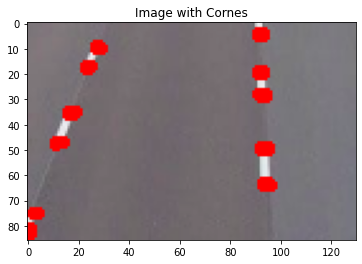

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

%matplotlib inline

# Read in the image
image = cv2.imread('line.png')

# Make a copy of the image
image_copy = np.copy(image)

# Change color to RGB (from BGR)
image_copy = cv2.cvtColor(image_copy, cv2.COLOR_BGR2RGB)

###YOUR CODE STARTS HERE

## STEP 1:  Convert to grayscale 

## STEP 2: Detect corners 

## STEP 3: Dilate corner image to enhance corner points

## STEP 4:set threshold value as 0.1 * (maximum value of dilated corner image obtained from STEP3)

## STEP 5: Count numer of detected corner points and draw them on the image
image_copy=cv2.cvtColor(image_copy, cv2.COLOR_RGB2GRAY)
corner=cv2.cornerHarris(image_copy, 2, 3, 0.04)
dilated=cv2.dilate(corner, None)
#image_copy[dilated > 0.1 * dilated.max()]=[0, 0, 255]   
count=0
for i in range(dilated.shape[0]):
    for j in range(dilated.shape[1]):
        if dilated[i,j]>0.1*dilated.max():
            count+=1
for i in range(dilated.shape[0]):
    for j in range(dilated.shape[1]):
        if dilated[i,j]>0.1*dilated.max():
            cv2.circle(image,(j,i),1,(255,0,0))
print("Number of Corners:")
print(count)
plt.imshow(image)
plt.title('Image with Cornes')
plt.show()     


### YOUR CODE ENDS HERE

# Part-2

In this section, we will train a neural network to learn to identify numerals from [MNIST](http://yann.lecun.com/exdb/mnist/) dataset. Fill out the missing pieces in each of the following cells. 

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import torch.nn.functional as F
import timeit
import unittest

## Please DONOT remove these lines. 
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(0)

### Data Loading and Pre-processing

In [ ]:
# check availability of GPU and set the device accordingly
#### YOUR CODE STARTS HERE ####
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# define a transforms for preparing the dataset
transform=transforms.Compose([
                               transforms.ToTensor(),
                               transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])
         # convert the image to a pytorch tensor
        # normalise the images with mean (0.1307) and std (0.3081) of the dataset
#### YOUR CODE ENDS HERE ####


In [ ]:
# Load the MNIST training, test datasets using `torchvision.datasets.MNIST` using the transform defined above
#### YOUR CODE STARTS HERE ####
import torchvision
train_dataset = torchvision.datasets.MNIST('/files/', train=True, download=True,
                             transform=transform)
test_dataset = torchvision.datasets.MNIST('/files/', train=False, download=True,
                             transform=transform)
#### YOUR CODE ENDS HERE ####

In [ ]:
# create dataloaders for training and test datasets
# use a batch size of 32 and set shuffle=True for the training set
#### YOUR CODE STARTS HERE ####
train_dataloader = torch.utils.data.DataLoader(train_dataset,
  batch_size=32, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset,
  batch_size=32, shuffle=True)
#### YOUR CODE ENDS HERE ####
dataiter = iter(train_dataloader)
images1, labels = dataiter.next()
print(type(images1))
print(images1.shape)
print(labels.shape)

<class 'torch.Tensor'>
torch.Size([32, 1, 28, 28])
torch.Size([32])


### Network Definition

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        #### YOUR CODE STARTS HERE ####
        # define a conv layer with output channels as 16, kernel size of 3 and stride of 1

        # define a conv layer with output channels as 32, kernel size of 3 and stride of 1
        
        # define a conv layer with output channels as 64, kernel size of 3 and stride of 1

        # define a max pooling layer with kernel size 2
        
        # define dropout layer with a probability of 0.25
        
        # define dropout layer with a probability of 0.5
        
        # define a linear(dense) layer with 128 output features
        
        # define a linear(dense) layer with output features corresponding to the number of classes in the dataset
        self.conv1 = nn.Conv2d(1, out_channels=16,stride=1, kernel_size=3)
        self.conv2 = nn.Conv2d(16, out_channels=32,stride=1, kernel_size=3)
        self.conv3 = nn.Conv2d(32, out_channels=64,stride=1, kernel_size=3)
        self.m = nn.MaxPool2d(2,stride=2)
        self.drop1 = nn.Dropout2d(p=0.25)
        self.drop2 = nn.Dropout2d(p=0.50)
        self.fc1 = nn.Linear(7744 , 128)
        self.fc2 = nn.Linear(128, 10)
        self.act = nn.ReLU()
        #### YOUR CODE ENDS HERE ####

    def forward(self, x):
        # Use the layers defined above in a sequential way (folow the same as the layer definitions above) and 
        # write the forward pass, after each of conv1, conv2, conv3 and fc1 use a relu activation. 
        # use the first dropout after maxpool and the other one before you final FC layer
        #### YOUR CODE STARTS HERE ####
        x = self.act(self.conv3(self.act(self.conv2(self.act(self.conv1(x))))))
        x = self.drop1(self.m(x))
        x = self.drop2(x)
        out = self.fc2(self.act(self.fc1(x.reshape(x.size(0), -1))))
        #### YOUR CODE ENDS HERE ####
        output = F.log_softmax(out, dim=1)
        return output

### Sanity Check
Make sure all the tests below pass without any errors, before you proceed with the training part.

In [ ]:
import unittest

class TestImplementations(unittest.TestCase):
    
    # Dataloading tests
    def test_dataset(self):
        self.dataset_classes = ['0 - zero',
                                '1 - one',
                                '2 - two',
                                '3 - three',
                                '4 - four',
                                '5 - five',
                                '6 - six',
                                '7 - seven',
                                '8 - eight',
                                '9 - nine']
        self.assertTrue(train_dataset.classes == self.dataset_classes)
        self.assertTrue(train_dataset.train == True)
    
    def test_dataloader(self):        
        self.assertTrue(train_dataloader.batch_size == 32)
        self.assertTrue(test_dataloader.batch_size == 32)      
         
    def test_total_parameters(self):
        model = Net().to(device)
        self.assertTrue(sum(p.numel() for p in model.parameters()) == 1015946)

suite = unittest.TestLoader().loadTestsFromModule(TestImplementations())
unittest.TextTestRunner().run(suite)

...
----------------------------------------------------------------------
Ran 3 tests in 2.776s

OK


<unittest.runner.TextTestResult run=3 errors=0 failures=0>

### Training and Inference

In [ ]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
      #### YOUR CODE STARTS HERE ####
        # send the image, target to the device
        
        # flush out the gradients stored in optimizer

        # pass the image to the model and assign the output to variable named output
        
        # calculate the loss (use nll_loss in pytorch)
        
        # do a backward pass
        
        # update the weights
        data,target = data.to(device),target.to(device)
        model.zero_grad()
        output = model(data)
        loss = nn.NLLLoss()(output, target)
        loss.backward()
        optimizer.step()
      #### YOUR CODE ENDS HERE ####
        if batch_idx % 20 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

In [ ]:
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
          ### YOUR CODE STARTS HERE ####
            # send the image, target to the device
            
            # pass the image to the model and assign the output to variable named output
            data,target = data.to(device),target.to(device)
            test_loss += nn.NLLLoss()(model(data), target).item()# sum up batch loss
          #### YOUR CODE ENDS HERE ####
            pred = model(data).argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

### Question 4

Use Adam as the optimiser and train the model for 25 epochs. Report the train, test loss and accuracies along with the total time taken for training. (Use plots if required)

In [ ]:
from time import time
temp=Net().to(device)
op = torch.optim.Adam(temp.parameters(),lr=0.01)
start = time()
for epoch in range(1, 26):
    train(temp, device, train_dataloader, op, epoch)
    test(temp, device, test_dataloader)
stop = time()
print('Total time taken in seconds:')
print(stop-start)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.308026
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.285677
Train Epoch: 1 [1280/60000 (2%)]	Loss: 1.718247
Train Epoch: 1 [1920/60000 (3%)]	Loss: 1.236071
Train Epoch: 1 [2560/60000 (4%)]	Loss: 0.687110
Train Epoch: 1 [3200/60000 (5%)]	Loss: 0.768152
Train Epoch: 1 [3840/60000 (6%)]	Loss: 0.558336
Train Epoch: 1 [4480/60000 (7%)]	Loss: 0.715995
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.949263
Train Epoch: 1 [5760/60000 (10%)]	Loss: 0.305651
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.565600
Train Epoch: 1 [7040/60000 (12%)]	Loss: 0.370610
Train Epoch: 1 [7680/60000 (13%)]	Loss: 0.492437
Train Epoch: 1 [8320/60000 (14%)]	Loss: 0.970359
Train Epoch: 1 [8960/60000 (15%)]	Loss: 0.572249
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.864471
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.762900
Train Epoch: 1 [10880/60000 (18%)]	Loss: 0.438390
Train Epoch: 1 [11520/60000 (19%)]	Loss: 0.294081
Train Epoch: 1 [12160/60000 (20%)]	Loss: 0.719510
Train Epoch: 1 [12800/60000 (

### Question 5

Modify the network defined in the previous step to replace ReLU activations with Sigmoid and report the final test accuracy. Is there a drop in accuracy, what do you think is the reason? 

In [ ]:
class Sigmoid(nn.Module):
    def __init__(self):
        super(Sigmoid, self).__init__()
        self.sconv1 = nn.Conv2d(1, 16, 3, stride=1)
        self.sconv2 = nn.Conv2d(16, 32, 3, stride=1)
        self.sconv3 = nn.Conv2d(32, 64, 3, stride=1)
        self.smaxpool = nn.MaxPool2d(2, stride=2)
        self.sdropout1 = nn.Dropout2d(p=0.25)
        self.sdropout2 = nn.Dropout2d(p=0.5)
        self.sfc1 = nn.Linear(in_features=64*11*11, out_features=128)
        self.sfc2 = nn.Linear(128,10)
        self.sact = nn.Sigmoid()
    def forward(self, x):
        x = self.smaxpool(self.sact((self.sconv3(self.sact((self.sconv2(self.sact((self.sconv1(x))))))))))
        x = self.sdropout1(x)
        x = self.sdropout2(x)
        x = x.reshape(x.size(0), -1)
        x = self.sact(self.sfc1(x))
        x = self.sfc2(x)
        output = F.log_softmax(x, dim=1)
        return output
temp=Sigmoid().to(device)
op = torch.optim.Adam(temp.parameters(), lr=0.01)
start = time()
for epoch in range(1, 26):
    train(temp, device, train_dataloader, op, epoch)
    test(temp, device, test_dataloader)
stop = time()
print('Total time taken in seconds:')
print(stop-start)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.330792
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.335363
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.502434
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.451754
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.370890
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.501571
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.354498
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.335850
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.280325
Train Epoch: 1 [5760/60000 (10%)]	Loss: 2.276212
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.361542
Train Epoch: 1 [7040/60000 (12%)]	Loss: 2.413776
Train Epoch: 1 [7680/60000 (13%)]	Loss: 2.361208
Train Epoch: 1 [8320/60000 (14%)]	Loss: 2.357993
Train Epoch: 1 [8960/60000 (15%)]	Loss: 2.451169
Train Epoch: 1 [9600/60000 (16%)]	Loss: 2.338943
Train Epoch: 1 [10240/60000 (17%)]	Loss: 2.426405
Train Epoch: 1 [10880/60000 (18%)]	Loss: 2.423942
Train Epoch: 1 [11520/60000 (19%)]	Loss: 2.340563
Train Epoch: 1 [12160/60000 (20%)]	Loss: 2.315606
Train Epoch: 1 [12800/60000 (

Ans: The accuracy in Sigmoid decreases because in sigmoid, the curve becomes parallel to the x axis for large numbers(either poisitive or negative) i.e. sigmoid saturates for large numbers and creates a problem of **vanishing gradients**.

### Question 6

Train the network defined in Question-1 with a different optimiser other than Adam, do you see any difference in performance? Substantiate your observations with relevant explanations.

In [ ]:
from time import time
temp=Net().to(device)
op = torch.optim.SGD( temp.parameters(),lr=0.01)
start = time()
for epoch in range(1, 26):
    train(temp, device, train_dataloader, op, epoch)
    test(temp, device, test_dataloader)
stop = time()
print('Total time taken in seconds:')
print(stop-start)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.311248
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.305553
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.271294
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.284570
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.266497
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.204557
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.043999
Train Epoch: 1 [4480/60000 (7%)]	Loss: 1.524023
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.945186
Train Epoch: 1 [5760/60000 (10%)]	Loss: 0.598332
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.426750
Train Epoch: 1 [7040/60000 (12%)]	Loss: 0.631518
Train Epoch: 1 [7680/60000 (13%)]	Loss: 0.629433
Train Epoch: 1 [8320/60000 (14%)]	Loss: 0.663499
Train Epoch: 1 [8960/60000 (15%)]	Loss: 0.600181
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.246464
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.463348
Train Epoch: 1 [10880/60000 (18%)]	Loss: 0.668635
Train Epoch: 1 [11520/60000 (19%)]	Loss: 0.364985
Train Epoch: 1 [12160/60000 (20%)]	Loss: 0.246515
Train Epoch: 1 [12800/60000 (

Ans: In this the accuracy increases when compared with Adam Optimiser becuase SGD is more locally unstable and is more likely to converge to the minima at the flat or asymmetric basins/valleys which often have better generalization performance.Hence, SGD is performing better.



### Question 7

Initialize the `Conv2d` layers in the network defined in Question-1 `(Net)` with all ones (both weights and bias). Train the network with Adam optimizer and report the final test accuracy. Is there any difference in the performance? If yes, what do you think is the reason? 

In [ ]:
def weightsones(model):
  if isinstance(model, nn.Conv2d):
        nn.init.ones_(model.weight.data)
        nn.init.ones_(model.bias.data)
temp=Net().to(device)
op=torch.optim.Adam(temp.apply(weightsones).parameters(),lr=0.01)
start = time()
for epoch in range(1, 26):
    train(temp, device, train_dataloader, op, epoch)
    test(temp, device, test_dataloader)
stop = time()
print('Total time taken in seconds:')
print(stop-start)

Train Epoch: 1 [0/60000 (0%)]	Loss: 180133.281250
Train Epoch: 1 [640/60000 (1%)]	Loss: 3735.514893
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.292709
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2692.346436
Train Epoch: 1 [2560/60000 (4%)]	Loss: 13226.768555
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.304416
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.316028
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.300132
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.228673
Train Epoch: 1 [5760/60000 (10%)]	Loss: 2.311071
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.286412
Train Epoch: 1 [7040/60000 (12%)]	Loss: 2.292072
Train Epoch: 1 [7680/60000 (13%)]	Loss: 2.314132
Train Epoch: 1 [8320/60000 (14%)]	Loss: 2.308662
Train Epoch: 1 [8960/60000 (15%)]	Loss: 2.296112
Train Epoch: 1 [9600/60000 (16%)]	Loss: 2.295908
Train Epoch: 1 [10240/60000 (17%)]	Loss: 2.292526
Train Epoch: 1 [10880/60000 (18%)]	Loss: 2.314562
Train Epoch: 1 [11520/60000 (19%)]	Loss: 2.310230
Train Epoch: 1 [12160/60000 (20%)]	Loss: 2.314668
Train Epoch: 1



Ans: In this the accuracy decreases drastically because if all the weights are initialised with same weights then all the units in a layer behaves the same, i.e. the gradient will be same.

### Question 8

Initialize the network defined in Question-1 `(Net)` with Xavier's initialization ([torch.nn.init.xavier_normal](https://pytorch.org/docs/stable/nn.init.html))(for bias use zero). Train the network with Adam optimizer and report the final test accuracy.

In [ ]:
def weights(model):
  if isinstance(model, nn.Conv2d):
    nn.init.xavier_normal_(model.weight.data)
    nn.init.zeros_(model.bias.data)
temp=Net().to(device)
op = torch.optim.Adam(temp.apply(weights).parameters(),lr=0.01)
start = time()
for epoch in range(1, 26):
    train(temp, device, train_dataloader, op, epoch)
    test(temp, device, test_dataloader)
stop = time()
print('Total time taken in seconds:')
print(stop-start)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.308155
Train Epoch: 1 [640/60000 (1%)]	Loss: 1.854083
Train Epoch: 1 [1280/60000 (2%)]	Loss: 0.754636
Train Epoch: 1 [1920/60000 (3%)]	Loss: 0.906251
Train Epoch: 1 [2560/60000 (4%)]	Loss: 1.169121
Train Epoch: 1 [3200/60000 (5%)]	Loss: 0.679813
Train Epoch: 1 [3840/60000 (6%)]	Loss: 0.444026
Train Epoch: 1 [4480/60000 (7%)]	Loss: 0.511700
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.496924
Train Epoch: 1 [5760/60000 (10%)]	Loss: 0.743481
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.306545
Train Epoch: 1 [7040/60000 (12%)]	Loss: 0.350939
Train Epoch: 1 [7680/60000 (13%)]	Loss: 0.394781
Train Epoch: 1 [8320/60000 (14%)]	Loss: 0.726188
Train Epoch: 1 [8960/60000 (15%)]	Loss: 0.483468
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.537613
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.153508
Train Epoch: 1 [10880/60000 (18%)]	Loss: 0.305299
Train Epoch: 1 [11520/60000 (19%)]	Loss: 0.454880
Train Epoch: 1 [12160/60000 (20%)]	Loss: 0.495245
Train Epoch: 1 [12800/60000 (

### Question 9

Add three batch-norm layers to the network defined in `Question-1` and report the final test accuracy. How does batch-norm help? 

In [ ]:
from time import time
class Batch(nn.Module):
    def __init__(self):
        super(Batch, self).__init__()
        self.bconv1 = nn.Conv2d(1, 16, 3, stride=1)
        self.bnorm1 = nn.BatchNorm2d(16)
        self.bconv2 = nn.Conv2d(16,32,3, stride=1)
        self.bnorm2 = nn.BatchNorm2d(32)
        self.bconv3 = nn.Conv2d(32,64,3, stride = 1)
        self.bnorm3 = nn.BatchNorm2d(64)
        self.bmaxpool = nn.MaxPool2d(2, stride=2)
        self.bdrop1 = nn.Dropout2d(p=0.25)
        self.bdrop2 = nn.Dropout2d(p=0.5)
        self.bfc1 = nn.Linear(64*11*11, 128)
        self.bfc2 = nn.Linear(128,10)
        self.bact = nn.ReLU()
    def forward(self, x):
        x = self.bmaxpool(self.bact(self.bnorm3(self.bconv3(self.bact(self.bnorm2(self.bconv2(self.bact(self.bnorm1(self.bconv1(x))))))))))
        x = self.bdrop1(x)
        x = self.bdrop2(x)
        out = self.bfc2(self.bact(self.bfc1(x.reshape(x.size(0), -1))))
        output = F.log_softmax(out, dim=1)
        return output
model=Batch().to(device)
op1 = torch.optim.Adam(model.parameters(),lr=0.01)
start = time()
for epoch in range(1, 26):
    train(model, device, train_dataloader, op1, epoch)
    test(model, device, test_dataloader)
stop = time()
print('Total time taken in seconds:')
print(stop-start)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.348019
Train Epoch: 1 [640/60000 (1%)]	Loss: 1.905777
Train Epoch: 1 [1280/60000 (2%)]	Loss: 1.821816
Train Epoch: 1 [1920/60000 (3%)]	Loss: 0.879184
Train Epoch: 1 [2560/60000 (4%)]	Loss: 0.901002
Train Epoch: 1 [3200/60000 (5%)]	Loss: 0.738211
Train Epoch: 1 [3840/60000 (6%)]	Loss: 0.259799
Train Epoch: 1 [4480/60000 (7%)]	Loss: 0.357382
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.318645
Train Epoch: 1 [5760/60000 (10%)]	Loss: 0.469301
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.223997
Train Epoch: 1 [7040/60000 (12%)]	Loss: 0.515365
Train Epoch: 1 [7680/60000 (13%)]	Loss: 0.338400
Train Epoch: 1 [8320/60000 (14%)]	Loss: 0.224306
Train Epoch: 1 [8960/60000 (15%)]	Loss: 0.400068
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.089016
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.166580
Train Epoch: 1 [10880/60000 (18%)]	Loss: 0.285270
Train Epoch: 1 [11520/60000 (19%)]	Loss: 0.238700
Train Epoch: 1 [12160/60000 (20%)]	Loss: 0.137103
Train Epoch: 1 [12800/60000 (

Ans: Batch normalization solves the problem of internal covariate shift.The smoothness induces by batch norm provides a more predictive and stable behavior of the gradients which helps in faster training.

# Part-3 (Optional)

*   List item
*   List item



This section is un-graded and purely for practice. 

Main focus of this part is to help you flex the deep learning muscles built in the above part. You should build a network on the [SVHN dataset](http://ufldl.stanford.edu/housenumbers/). This dataset is similar to MNIST but unlike MNIST, the images are colored and more complex. 

As of writing this, the state-of-the-art(SoTA) performance on this dataset is 98.98%. You can try to start with the simple network we defined above for the MNSIT dataset(with some modification for dealing with different sized colored images unlike MNIST). But to achive the SoTA performance you need to do a lot of hackery. These are list of few things, we would encourage you to try: 

- Use data augmentation wisely. Read and understand how to perform the augmentations listed below. 
    * RandomFlips, Color Jittering
    * Cutout, Cutmix
    * Mixup
    * Auto-augment

- Try to increase the image size using standard image interpolation techniques. Try using tricks like Progressive resizing of images and see if it helps. 

- After certain number of layers, adding more layer might not be of much help, run experiments on SVHN and see if you observe this. 

- To understand the difficulties in training deeper networks read this paper: [Deep Residual Learning for Image Recognition](https://arxiv.org/abs/1512.03385)

- To improve the performance on SVHN, try using architectures like [ResNet](https://arxiv.org/abs/1512.03385), [DesnseNet](https://arxiv.org/abs/1608.06993) or [EfficientNet](https://arxiv.org/abs/1905.11946). Most of these architectures are available by default in PyTorch.
